# Install Packages and Import Libraries

In [1]:
# Install font for showing Korean in graphs of plt and sns libraries. (그래프에서 한글 사용을 위한 패키지 설치)
# After running this cell, Make sure to turn these 3 lines of code into comment lines (이 셀을 실행`시킨 후 아래 세 줄의 코드를 주석 처리 )
# Then, click "Runtime" on the Menubar and click "Restart and run all" for running code cells sequentially in this notebook (상단 메뉴의 "런타임" - "다시 시작 및 모두 실행"을 클릭하여 런타임 재시작 후 노트북 모두 실행)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [2]:
import seaborn as sns
import pandas as pd
import re
import warnings
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

# Data
- movie_data.csv file that download from github

In [3]:
data = pd.read_csv(
    '/content/movie_data.csv', encoding="cp949").drop(columns='Unnamed: 0')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1115 non-null   object 
 1   director           1113 non-null   object 
 2   distributor        1115 non-null   object 
 3   distributor_group  1087 non-null   object 
 4   release_date       1115 non-null   int64  
 5   release_season     1115 non-null   object 
 6   nation             1115 non-null   object 
 7   screen             1115 non-null   int64  
 8   rev_nationwide     1115 non-null   float64
 9   aud_nationwide     1115 non-null   int64  
 10  genre              1115 non-null   object 
 11  rate               1115 non-null   object 
 12  type               1115 non-null   object 
 13  starring_actors    1114 non-null   object 
 14  running_times      1115 non-null   int64  
 15  release_year       1115 non-null   int64  
 16  director_power     1115 

In [5]:
df = data.copy()

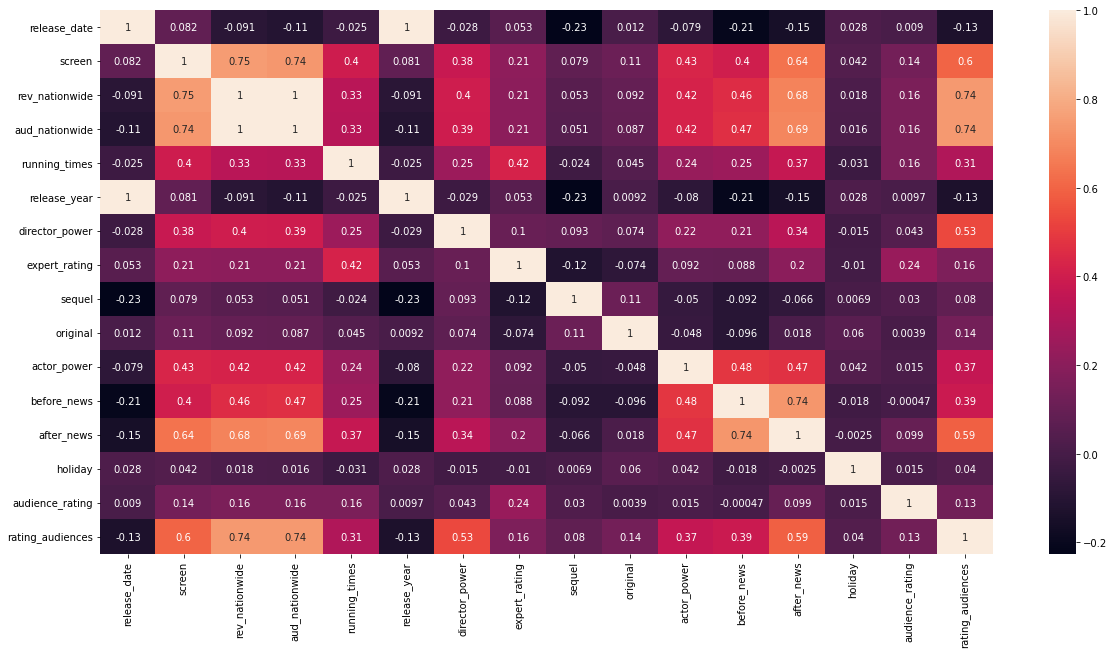

In [6]:
plt.figure(figsize=(20,10))
correlation_mat = df.corr() # Except categorical features
sns.heatmap(correlation_mat, annot = True)
plt.show()

In [7]:
df = df.drop(columns=['distributor_group', 'release_date','title', 'director', 'distributor', 'rev_nationwide', 'release_year','type', 'starring_actors', 'release_season', 'holiday'])

In [8]:
cat_features = ['dist_cat', 'rate','nation', 'genre']

for column in cat_features:
	temp = pd.get_dummies(pd.Series(df[column]))
	df = pd.concat([df,temp],axis=1)
	df = df.drop([column],axis=1)

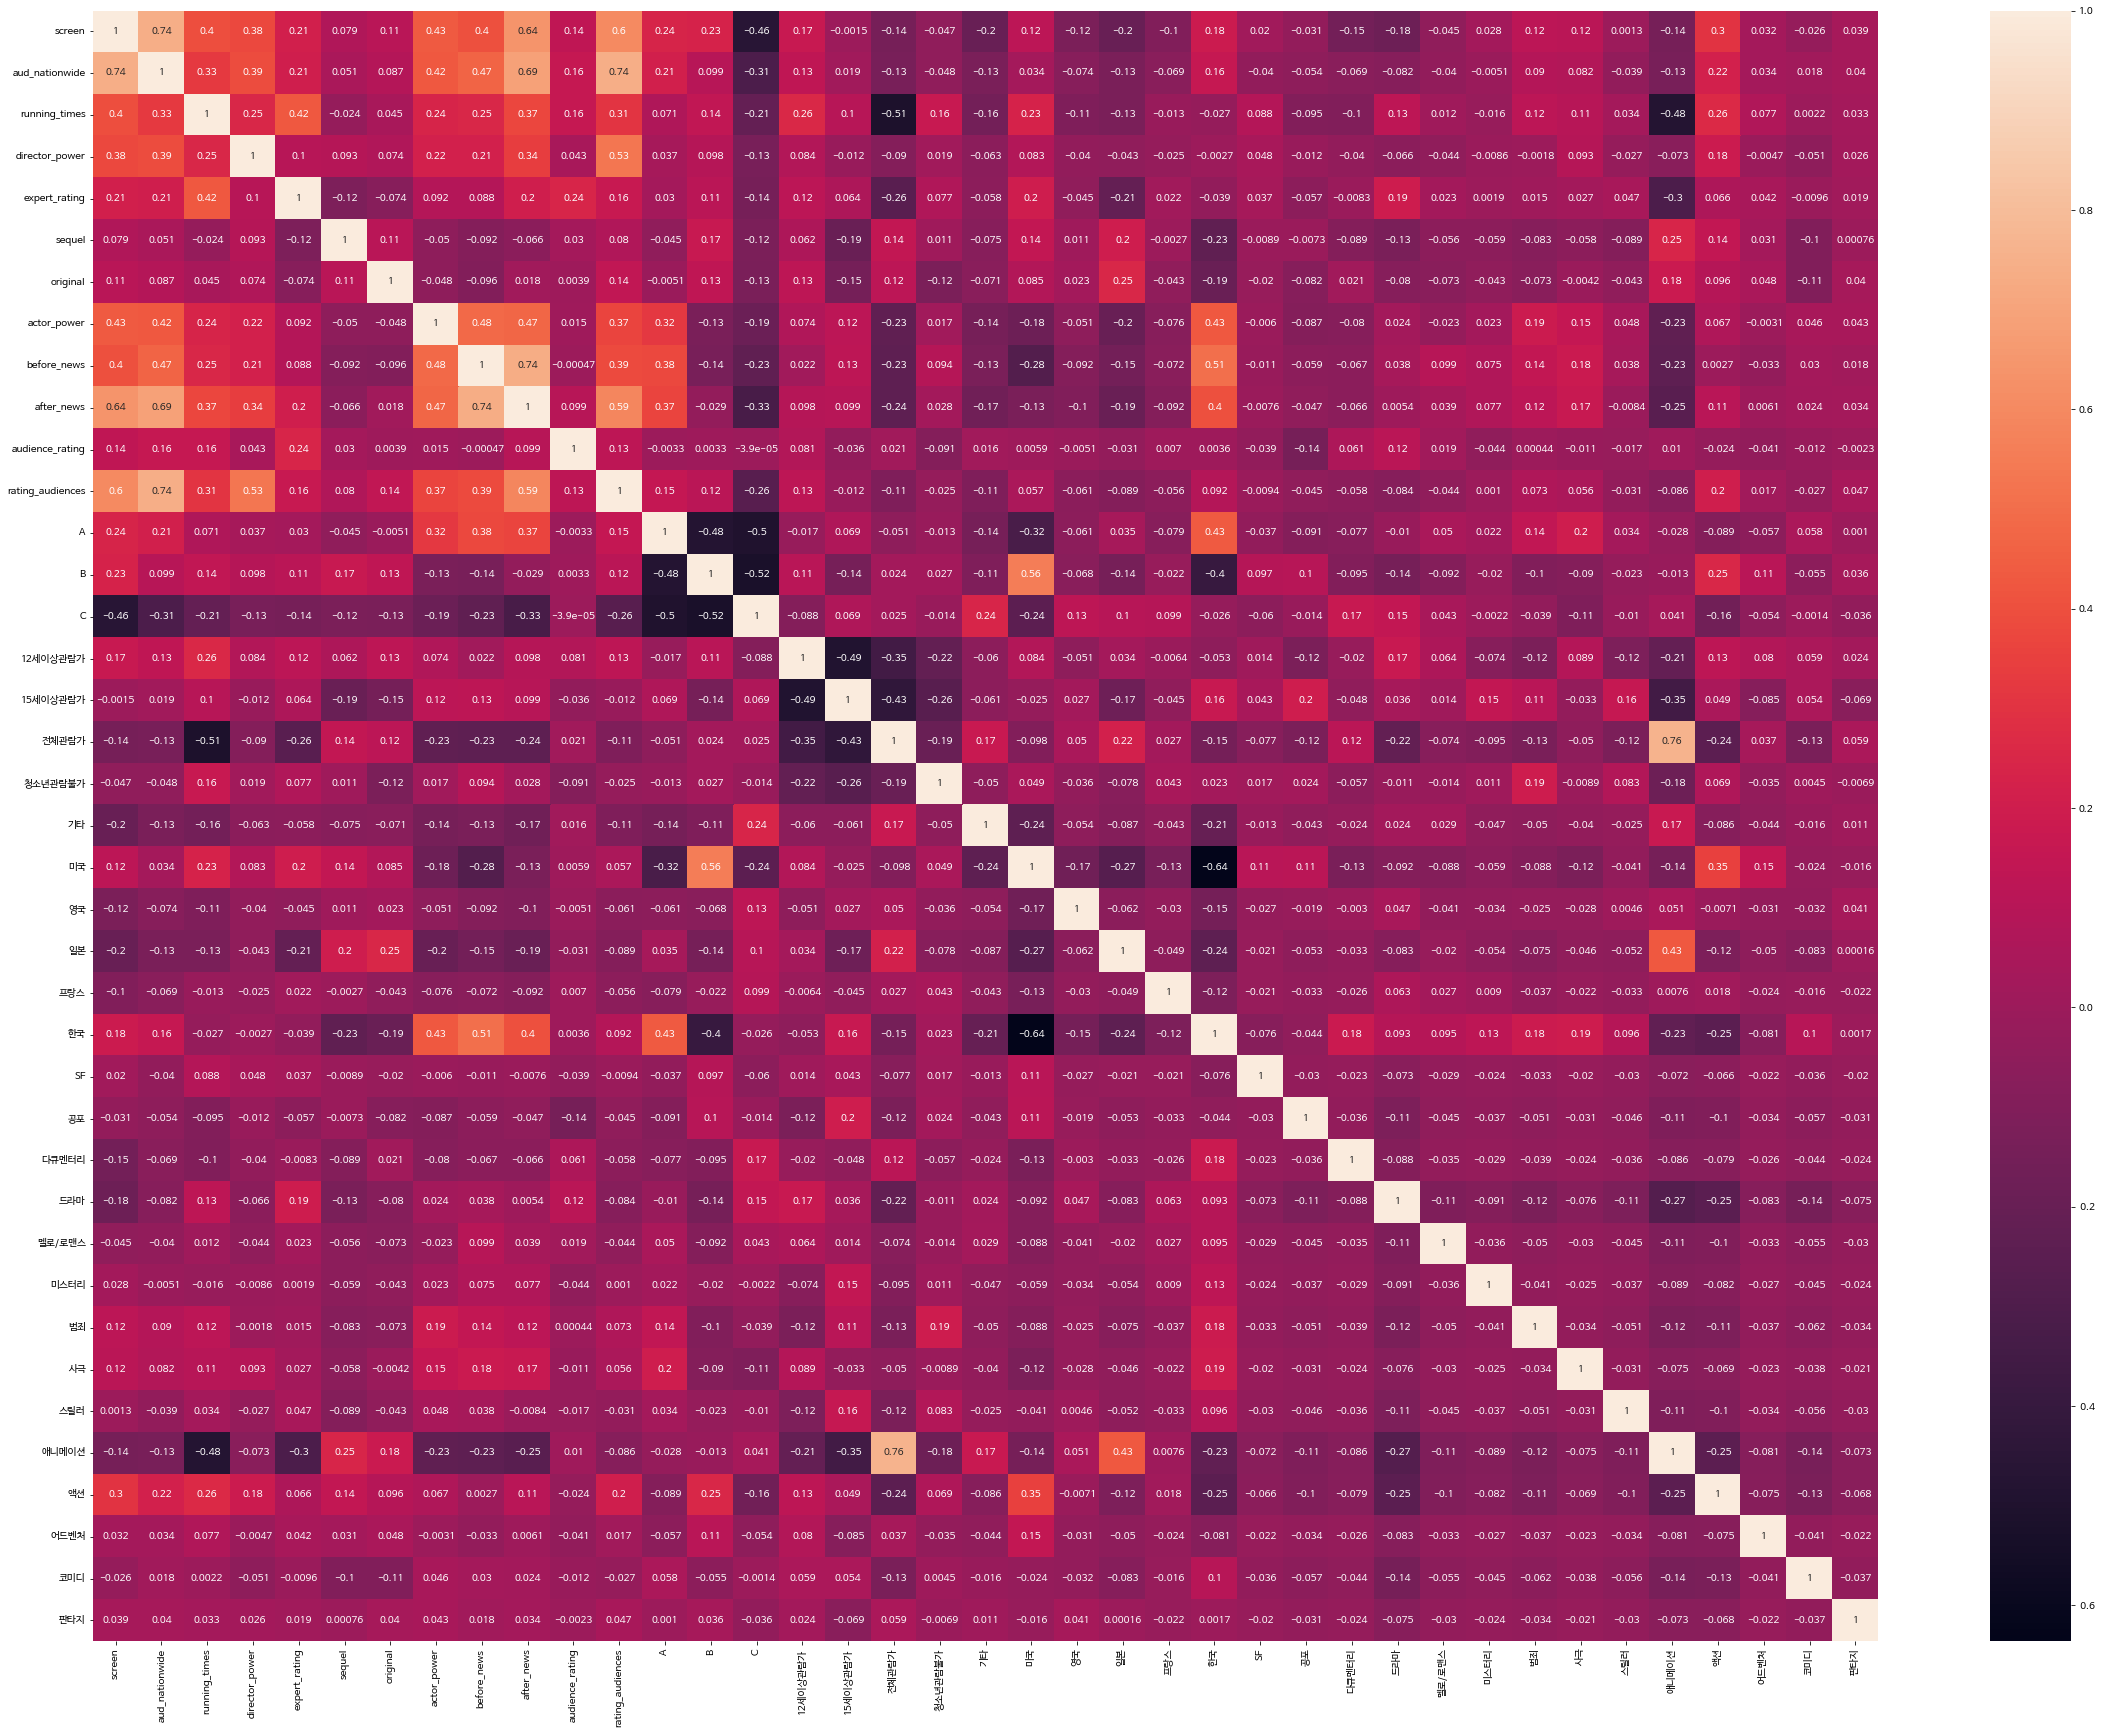

In [9]:
plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize=(40,30)) 
correlation_mat = df.corr() # Include categorical features
sns.heatmap(correlation_mat, annot = True)
plt.show()

In [10]:
df1 = df.iloc[:925,:] # Training and Testing datasets
df2 = df.iloc[925:,:] # Datasets for 2021 to evaluate model

In [11]:
y = df1['aud_nationwide']
X = df1.drop(columns=['aud_nationwide'])

y2 = df2['aud_nationwide']
X2 = df2.drop(columns=['aud_nationwide'])

In [12]:
# Spliting datasets to training datasets and testing datasets
X_train_ori, X_test_ori, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2022
)

# Experiments
- screen, expert_rating, audience_rating, running_times, sequel, original, nation,  genre, rate, dist_cat
- Add actor_power, director_power features
- Add before_news, after_news features
- Add rating_audiences feature
- grid search


## model1
- Use independent variables that papers we refered to have used
- Apply 10 features
    - screen, expert_rating, audience_rating, running_times, sequel, original, nation,  genre, rate, dist_cat
- Compare performance of LightGBM and XGBoost


In [13]:
X_train = X_train_ori.copy()
X_test = X_test_ori.copy()

In [14]:
# Use 10 independent variables
X_train = X_train.drop(columns=['actor_power', 'director_power','after_news', 'before_news', 'rating_audiences'])
X_test = X_test.drop(columns=['actor_power', 'director_power', 'after_news','before_news', 'rating_audiences'])

In [15]:
# Standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

In [17]:
from sklearn.model_selection import KFold
import lightgbm as lgb
from xgboost import XGBRegressor

# K-Fold Cross Validation
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 777)

model_lgbm = lgb.LGBMRegressor(random_state = 777)
model_xgboost = XGBRegressor(random_state = 777, objective='reg:squarederror')

models_lgbm = []
models_xgboost = []

for train_idx, val_idx in k_fold.split(X_train_scaled):
    x_t = X_train_scaled.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train_scaled.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models_lgbm.append(model_lgbm.fit(x_t, y_t, eval_set = (x_val, y_val), early_stopping_rounds = 100, verbose = 100))
    models_xgboost.append(model_xgboost.fit(x_t, y_t, eval_set = [(x_val, y_val)], early_stopping_rounds = 100, verbose = 100))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 8.58704e+11
Did not meet early stopping. Best iteration is:
[91]	valid_0's l2: 8.46992e+11
[0]	validation_0-rmse:1.76257e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:908860
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 1.24687e+12
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 9.36918e+11
[0]	validation_0-rmse:1.73127e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:1.02915e+06
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 5.56329e+11
Did not meet early stopping. Best iteration is:
[95]	valid_0's l2: 5.46702e+11
[0]	validation_0-rmse:1.76864e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:680023
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 

In [18]:
# X_test로 결과값 예측
from sklearn.metrics import accuracy_score
import numpy as np
preds_lgbm = []
preds_xgboost = []

for model in models_lgbm:
    y_pred = model.predict(X_test_scaled)
    preds_lgbm.append(model.predict(X_test_scaled))

for model in models_xgboost:
    y_pred = model.predict(X_test_scaled)
    preds_xgboost.append(model.predict(X_test_scaled))

y_pred_lgbm = np.mean(preds_lgbm, axis=0)
y_pred_xgboost = np.mean(preds_xgboost, axis=0)

In [19]:
from sklearn.metrics import mean_squared_error

print(f'LGBM RMSE for model1: {mean_squared_error(y_test, y_pred_lgbm, squared=False)}')
print(f'XGBoost RMSE for model 1: {mean_squared_error(y_test, y_pred_xgboost, squared=False)}')

LGBM RMSE for model1: 1023582.3394008934
XGBoost RMSE for model 1: 1007172.5798462731


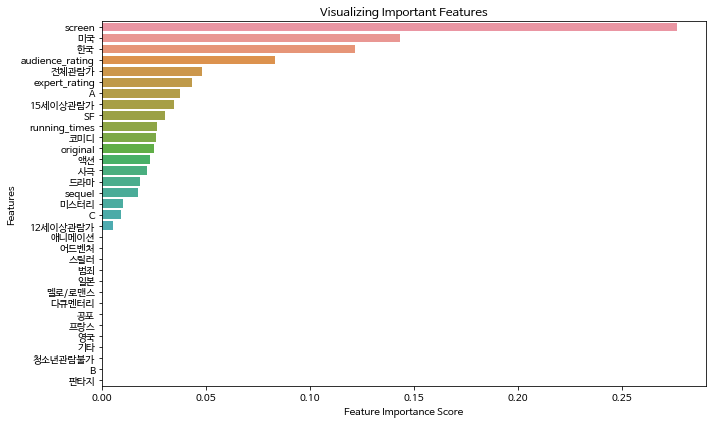

In [20]:
feature_imp = pd.Series(model_xgboost.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.rc('font', family='NanumBarunGothic') 
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

## model2
- Add actor_power, director_power features

In [21]:
X_train = X_train_ori.copy()
X_test = X_test_ori.copy()

In [22]:
X_train = X_train.drop(columns=['after_news', 'before_news', 'rating_audiences'])
X_test = X_test.drop(columns=['after_news','before_news', 'rating_audiences'])

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

In [25]:
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 777)

model_xgboost2 = XGBRegressor(random_state = 777, objective='reg:squarederror')

models_xgboost2 = []

for train_idx, val_idx in k_fold.split(X_train_scaled):
    x_t = X_train_scaled.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train_scaled.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models_xgboost2.append(model_xgboost2.fit(x_t, y_t, eval_set = [(x_val, y_val)], early_stopping_rounds = 100, verbose = 100))

[0]	validation_0-rmse:1.76257e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:971163
[0]	validation_0-rmse:1.73127e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:981023
[0]	validation_0-rmse:1.76332e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:709795
[0]	validation_0-rmse:2.21959e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:1.17166e+06
[0]	validation_0-rmse:3.07915e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:1.50005e+06


In [26]:
preds_xgboost2 = []

for model in models_xgboost2:
    y_pred = model.predict(X_test_scaled)
    preds_xgboost2.append(model.predict(X_test_scaled))

y_pred_xgboost2 = np.mean(preds_xgboost2, axis=0)

In [27]:
print(f'XGBoost RMSE for model2: {mean_squared_error(y_test, y_pred_xgboost2, squared=False)}')

XGBoost RMSE for model2: 940578.1781628435


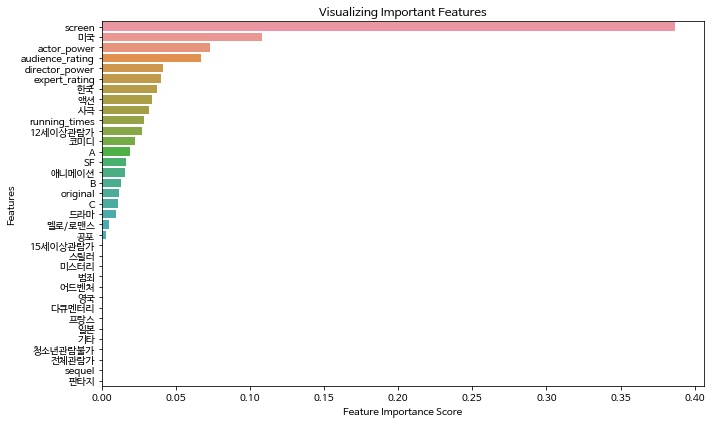

In [28]:
feature_imp2 = pd.Series(model_xgboost2.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.rc('font', family='NanumBarunGothic') 
sns.barplot(x=feature_imp2, y=feature_imp2.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

## model3
- Add before_news, after_news features

In [29]:
X_train = X_train_ori.copy()
X_test = X_test_ori.copy()

In [30]:
X_train = X_train.drop(columns=['rating_audiences'])
X_test = X_test.drop(columns=['rating_audiences'])

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

In [33]:
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 777)

model_xgboost3 = XGBRegressor(random_state = 777, objective='reg:squarederror')

models_xgboost3 = []

for train_idx, val_idx in k_fold.split(X_train_scaled):
    x_t = X_train_scaled.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train_scaled.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    models_xgboost3.append(model_xgboost3.fit(x_t, y_t, eval_set = [(x_val, y_val)], early_stopping_rounds = 100, verbose = 100))

[0]	validation_0-rmse:1.76118e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:939587
[0]	validation_0-rmse:1.74945e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:901853
[0]	validation_0-rmse:1.77139e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:678209
[0]	validation_0-rmse:2.22453e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:1.26727e+06
[0]	validation_0-rmse:3.08801e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:1.52975e+06


In [34]:
preds_xgboost3 = []

for model in models_xgboost3:
    y_pred = model.predict(X_test_scaled)
    preds_xgboost3.append(model.predict(X_test_scaled))

y_pred_xgboost3 = np.mean(preds_xgboost3, axis=0)

In [35]:
print(f'RMSE for model 3: {mean_squared_error(y_test, y_pred_xgboost3, squared=False)}')

RMSE for model 3: 866668.5282001502


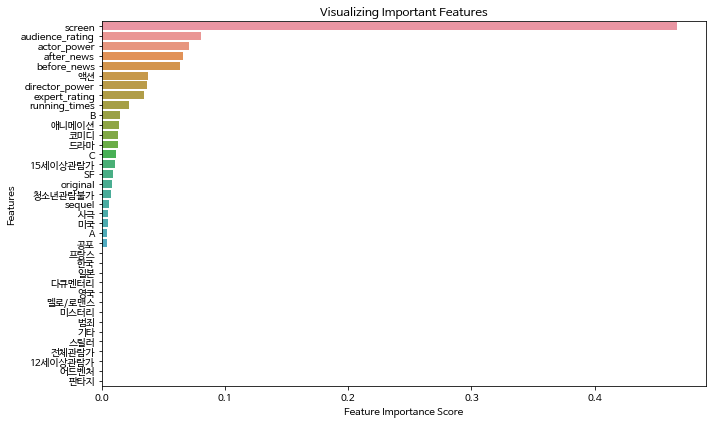

In [36]:
feature_imp3 = pd.Series(model_xgboost3.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.rc('font', family='NanumBarunGothic') 
sns.barplot(x=feature_imp3, y=feature_imp3.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

## model4
- Add rating_audiences feature

In [37]:
X_train = X_train_ori.copy()
X_test = X_test_ori.copy()

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
X_train_scaled = pd.DataFrame(X_train_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled)

In [40]:
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 777)

model_xgboost4 = XGBRegressor(random_state = 777, objective='reg:squarederror')
models_xgboost4 = []

for train_idx, val_idx in k_fold.split(X_train_scaled):
    x_t = X_train_scaled.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train_scaled.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models_xgboost4.append(model_xgboost4.fit(x_t, y_t, eval_set = [(x_val, y_val)], early_stopping_rounds = 100, verbose = 100))

[0]	validation_0-rmse:1.76087e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:921422
[0]	validation_0-rmse:1.72659e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:796346
[0]	validation_0-rmse:1.76938e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:669816
[0]	validation_0-rmse:2.22615e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:1.14441e+06
[0]	validation_0-rmse:3.08347e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:1.29618e+06


In [41]:
preds_xgboost4 = []

for model in models_xgboost4:
    y_pred = model.predict(X_test_scaled)
    preds_xgboost4.append(model.predict(X_test_scaled))

y_pred_xgboost4 = np.mean(preds_xgboost4, axis=0)

In [42]:
print(f'XGBoost RMSE for model4: {mean_squared_error(y_test, y_pred_xgboost4, squared=False)}')

XGBoost RMSE for model4: 743427.8375634109


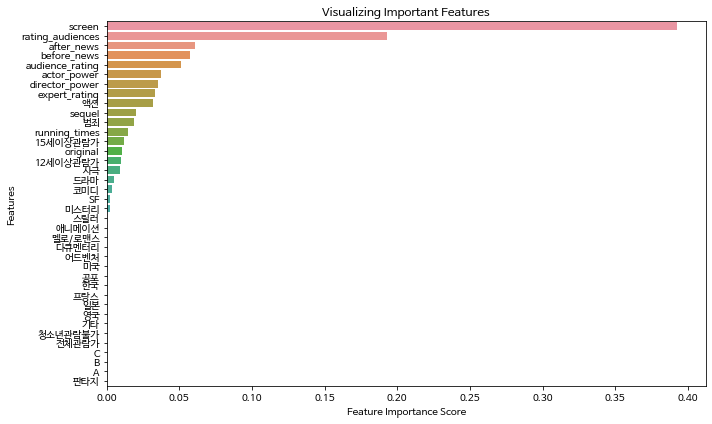

In [43]:
feature_imp4 = pd.Series(model_xgboost4.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.rc('font', family='NanumBarunGothic') 
sns.barplot(x=feature_imp4, y=feature_imp4.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

## RandomizedSearch
- Hyperparameter tuning

In [44]:
from sklearn.model_selection import RandomizedSearchCV

# Use RandomizedSearchCV to find Optimal Parameters
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 777)
model_xgboost_r = XGBRegressor(random_state = 777, objective='reg:squarederror')

params_xgboost = {
    'n_estimators': [100, 500, 1000, 2000],
    'learning_rate': [0.3, 0.1, 0.01, 0.003],
    'max_depth' : [3, 6, 8, 10] 
}

rs_xgboost = RandomizedSearchCV( 
                 estimator = model_xgboost_r,
                 param_distributions = params_xgboost,
                 scoring = 'neg_root_mean_squared_error',
                 cv = k_fold)

models_xgboost_r = []

for train_idx, val_idx in k_fold.split(X_train_scaled):
    x_t = X_train_scaled.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    x_val = X_train_scaled.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models_xgboost_r.append(rs_xgboost.fit(x_t, y_t, eval_set = [(x_val, y_val)], early_stopping_rounds = 100, verbose = 100))

[0]	validation_0-rmse:1.74742e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:907560
[0]	validation_0-rmse:1.74878e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:995106
[0]	validation_0-rmse:1.75036e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:991841
[0]	validation_0-rmse:1.75926e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:1.03573e+06
[0]	validation_0-rmse:1.75e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[99]	validation_0-rmse:964728
[0]	validation_0-rmse:1.51469e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:909440
Stopping. Best iteration:
[27]	validation_0-rmse:883224

[0]	validation_0-rmse:1.5132e+06
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:809885
Stopping. Best iteration:
[18]

In [45]:
# evaluate the model with the best parameters chosen through tuning
preds_r = []
for model in models_xgboost_r:
  preds_r.append(model.predict(X_test_scaled))
pred_r = np.mean(preds_r, axis = 0)
print(f'RMSE after RandomizedSearch: {mean_squared_error(y_test, pred_r, squared=False)}')

RMSE after RandomizedSearch: 742844.4021508528


In [46]:
print(f'best parameters: {rs_xgboost.best_params_ }')

best parameters: {'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.1}


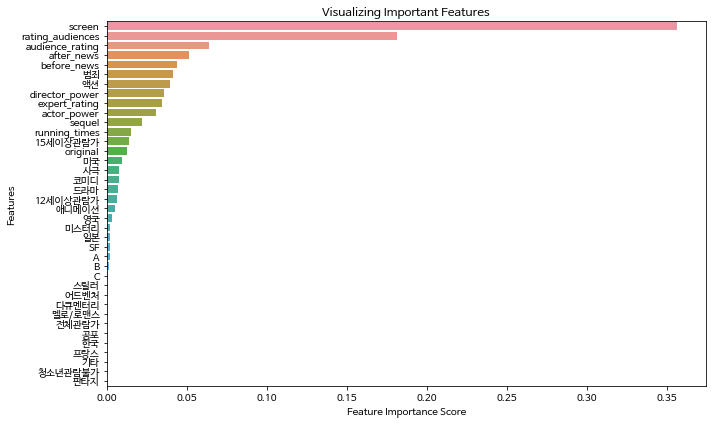

In [47]:
feature_imp5 = pd.Series(rs_xgboost.best_estimator_.feature_importances_, index=X_train.columns.values).sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.rc('font', family='NanumBarunGothic') 
sns.barplot(x=feature_imp5, y=feature_imp5.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

# Results

## Result 1(Prediction result for test datasets by best model)


In [48]:
dict1 = dict(zip(enumerate(y_test), pred_r))
sorted_dict = {key: dict1[key] for key in sorted(dict1.keys(), key = lambda ele: ele[1])}

In [49]:
y_test_r = []
pred_r = []
for key, value in sorted_dict.items():
  y_test_r.append(key[1])
  pred_r.append(value)

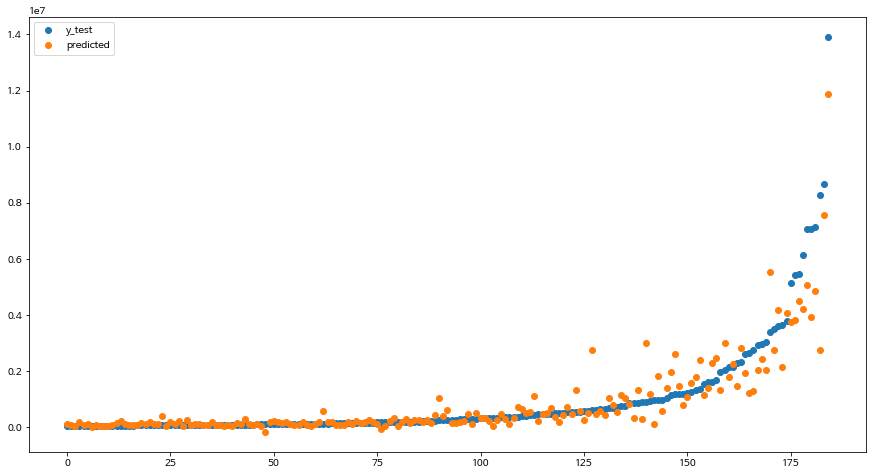

In [50]:
plt.figure(figsize=(15,8))
plt.scatter([i for i in range(0, len(y_test))], y_test_r, label='y_test')
plt.scatter([i for i in range(0, len(y_test))], pred_r, label='predicted')
plt.legend()
plt.show()

##Result 2(Prediction result for 2021 datasets)


In [51]:
X_scaled2 = scaler.transform(X2)
X_scaled2 = pd.DataFrame(X_scaled2)

In [52]:
pred2021 = []
for model in models_xgboost_r:
  y_pred = model.predict(X_scaled2)
  pred2021.append(model.predict(X_scaled2))
y_pred2021 = np.mean(pred2021, axis=0)

In [53]:
dict1 = dict(zip(enumerate(y2), y_pred2021))
sorted_dict = {key: dict1[key] for key in sorted(dict1.keys(), key = lambda ele: ele[1])}

In [54]:
y_test_2021 = []
pred_2021 = []
for key, value in sorted_dict.items():
  y_test_2021.append(key[1])
  pred_2021.append(value)

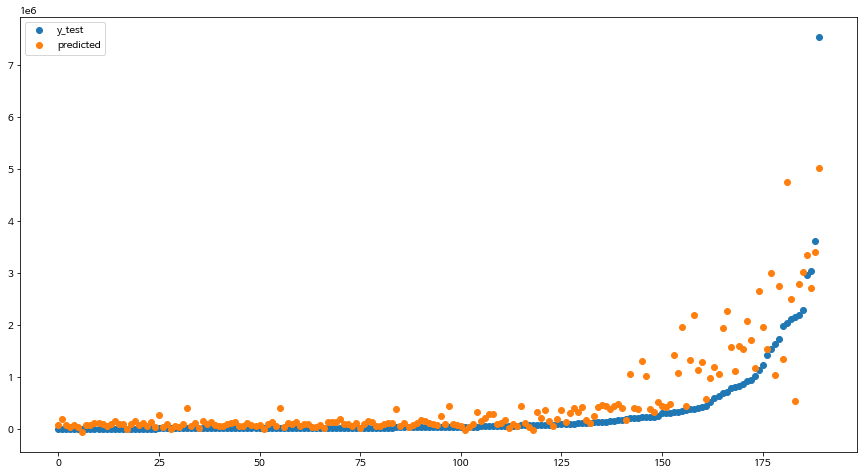

In [55]:
plt.figure(figsize=(15,8))
plt.scatter([i for i in range(0, len(y_test_2021))], y_test_2021, label='y_test')
plt.scatter([i for i in range(0, len(y_test_2021))], pred_2021, label='predicted')
plt.legend()
plt.show()